In [13]:
from initialization import Location
from initialization import Grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties


# Base Model

In [8]:
# Parameters
beta = 0.3 
mu = 0.1
population = 1000 
initial_infected = 1  
initial_susceptible = population - initial_infected  
initial_recovered = 0 
days = 100  

# Create arrays to store the results
susceptible = np.zeros(days)
infectious = np.zeros(days)
recovered = np.zeros(days)

# Initialize the initial conditions
susceptible[0] = initial_susceptible
infectious[0] = initial_infected
recovered[0] = initial_recovered

# Simulate the SIR model
for day in range(1, days):
    new_infections = beta * susceptible[day - 1] * infectious[day - 1] / population
    new_recoveries = mu * infectious[day - 1]

    susceptible[day] = susceptible[day - 1] - new_infections
    infectious[day] = infectious[day - 1] + new_infections - new_recoveries
    recovered[day] = recovered[day - 1] + new_recoveries

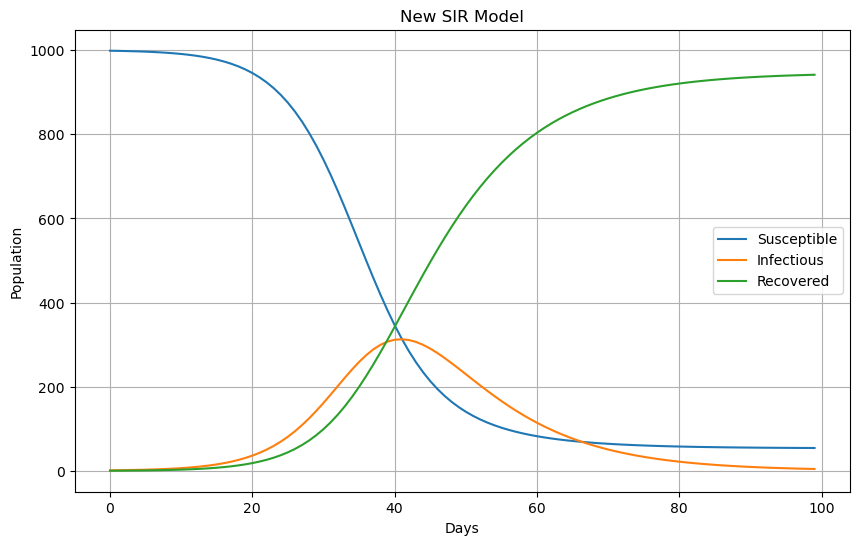

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(susceptible, label="Susceptible")
plt.plot(infectious, label="Infectious")
plt.plot(recovered, label="Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.title("New SIR Model")
plt.grid(True)
plt.show()

In [14]:
def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

# Mobility Based SIR Model w/ Dynamic Social and Outside Connectivity - Random, High, Low

In [15]:
def dynamic_alpha_connectivity(beta, mu, N, n_locations, days, alpha_range, trials, outside_connectivity):

    alpha_connectivity_sir = {}
    for alpha in alpha_range:
        for c in outside_connectivity:
            for trial in range(trials):
                alpha_connectivity_sir[(alpha,c)] = []
                # Create arrays to store the results
                infectious = np.zeros(days)
                #Initialize grid and locations
                grid = Grid(n_locations, N, alpha, beta, mu)

                grid.random_orgin()

                grid.edit_connections(c)

                day = 0
                for day in range(days):
                    for loc in grid.map:
                        if loc.n != 0:
                            infections, total_connections = get_other_loc_params(grid, loc)
                            
                            new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                            
                            new_recoveries = (mu * loc.i)

                            loc.s = loc.s - new_infections
                            loc.i = loc.i + new_infections - new_recoveries
                            loc.r = loc.r + new_recoveries

                            infectious[day] += loc.i
                alpha_connectivity_sir[(alpha,c)].append(np.argmax(infectious))

            alpha_connectivity_sir[(alpha,c)] = np.mean(alpha_connectivity_sir[(alpha,c)])

    return list(alpha_connectivity_sir.values())
    

In [16]:
def plotting_dynamic_alpha_connectivity(alpha_range, outside_connectivity, max_infections):
    x, y = np.meshgrid(alpha_range, outside_connectivity[::-1])
    font_bold = FontProperties(weight="bold")
    z = []
    for i in range(len(outside_connectivity)):
        miniList = []
        for j in range(len(alpha_range)):
            miniList.append(max_infections.pop(0))
        z.append(miniList)
    z = np.array(z)

    fig = plt.figure(figsize = (18, 20))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(x, y, z, cmap='viridis')
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

    ax.set_xlabel('Social Connectivity Alpha', fontproperties=font_bold)
    ax.set_ylabel('Outside Connectivity', fontproperties=font_bold)
    ax.set_zlabel('Max Infections', fontproperties=font_bold)
    ax.set_title('Combining Alpha and Outside Connectivity', fontproperties=font_bold, fontsize=25)

    plt.show()

### SIR Model w/ Dynamic Alpha and Outside Connectivity

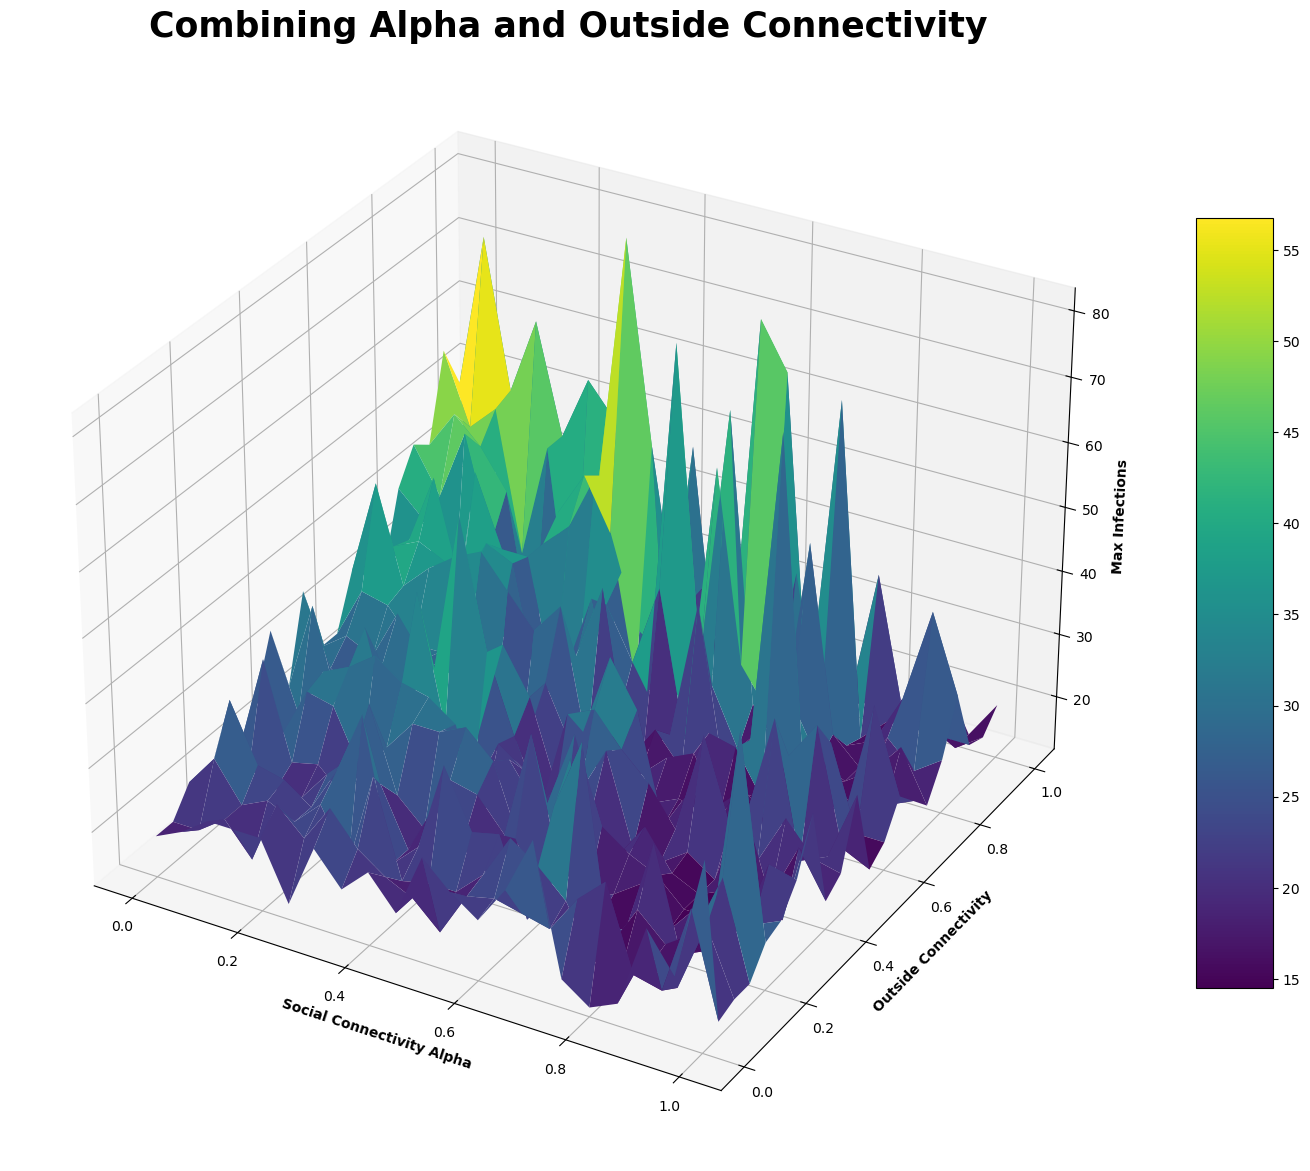

In [20]:
# Parameters
beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
N = 100000
n_locations=50
days = 100
alpha_range = np.arange(0,1.05,0.05)
outside_connectivity = np.arange(0,1.05,0.05)
trials=5

max_infections = dynamic_alpha_connectivity( beta, mu, N, n_locations, days, alpha_range, trials, outside_connectivity)
plotting_dynamic_alpha_connectivity(alpha_range, outside_connectivity, max_infections)

In [16]:
plotting_dynamic_alpha_connectivity(alpha_range, outside_connectivity, max_infections)

IndexError: pop from empty list

# Mobility Based SIR Models - Random, High, and Low

In [17]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials):
    alpha_sir = {}
    for alpha in alpha_range:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)
                

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i / loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) #/ loc.n
                        #print("r",loc.i, new_recoveries)

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1-(1/N))
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [18]:
import matplotlib.pyplot as plt
import numpy as np
def sir_plotting(results, type):
    translation = {0: "S", 1: "I", 2: "R"}

    # Calculate the number of rows and columns based on the number of results
    num_rows = len(results) // 2 + len(results) % 2
    num_cols = 2


    # Set the figure size
    plt.figure(figsize=(15, 5 * num_rows))

    for idx, (key, values) in enumerate(results.items()):
        # Create subplots
        plt.subplot(num_rows, num_cols, idx + 1)

        for sublist in values:
            plt.plot(sublist, label=translation[values.index(sublist)], linewidth=5)
            if type != "Random" and type != "High":
                type = "Low"
            font_bold = FontProperties(weight="bold")
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {round(key,1)}', fontproperties=font_bold)

        plt.legend()
        plt.xlabel("Time (Days)", fontproperties=font_bold)
        plt.ylabel("Population Density", fontproperties=font_bold)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

### SIR Model with Random Origin and Dynamic Alpha

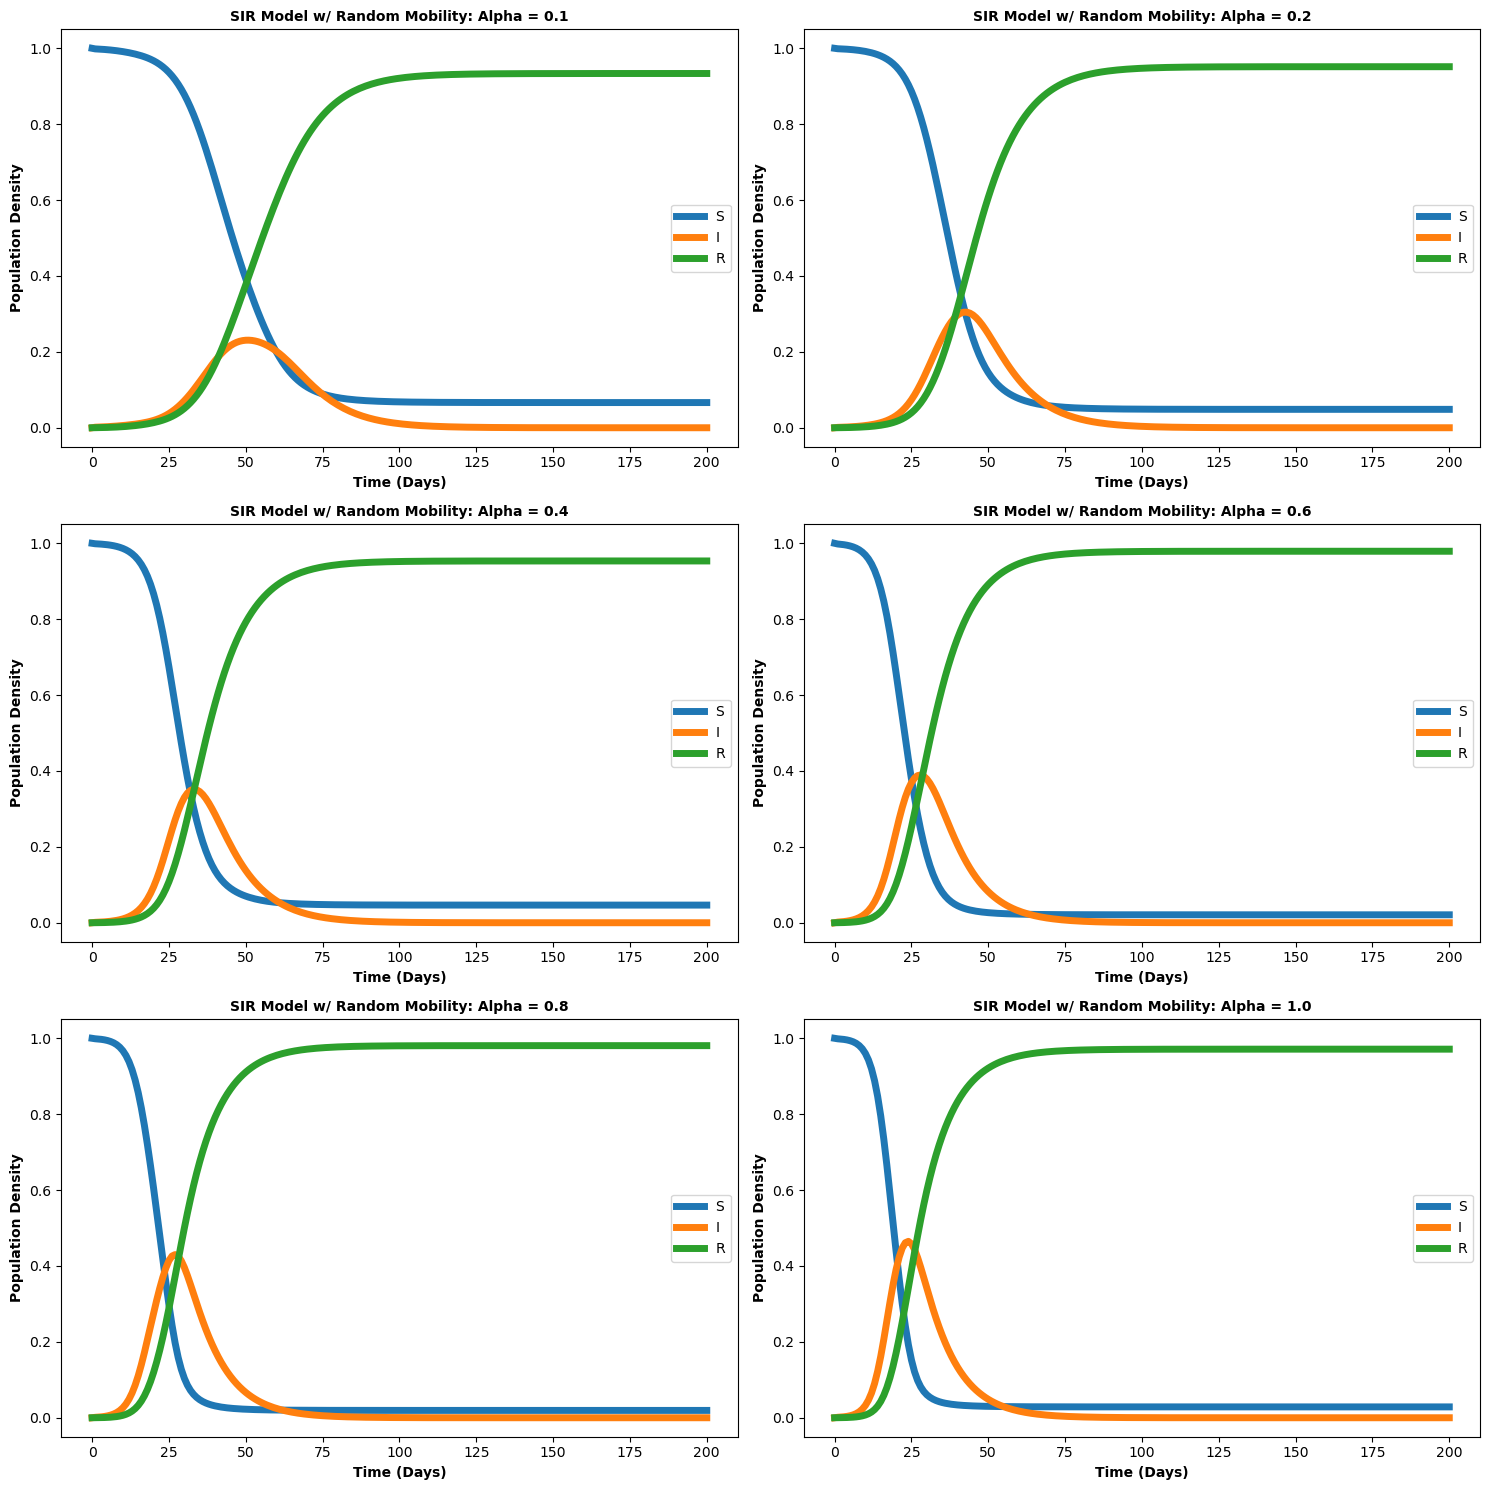

In [19]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
N = 1000000
n_locations=50
days = 200
alphas = [0.1,0.2,0.4,0.6,0.8,1.0]
trials=10
#c = 0
type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
sir_plotting(dynamic_alpha_results, type)


### SIR Model with High Mobility and Dynamic Alpha

In [ ]:
type = "High"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results, type)


### SIR Model with Low Mobility and Dynamic Alpha

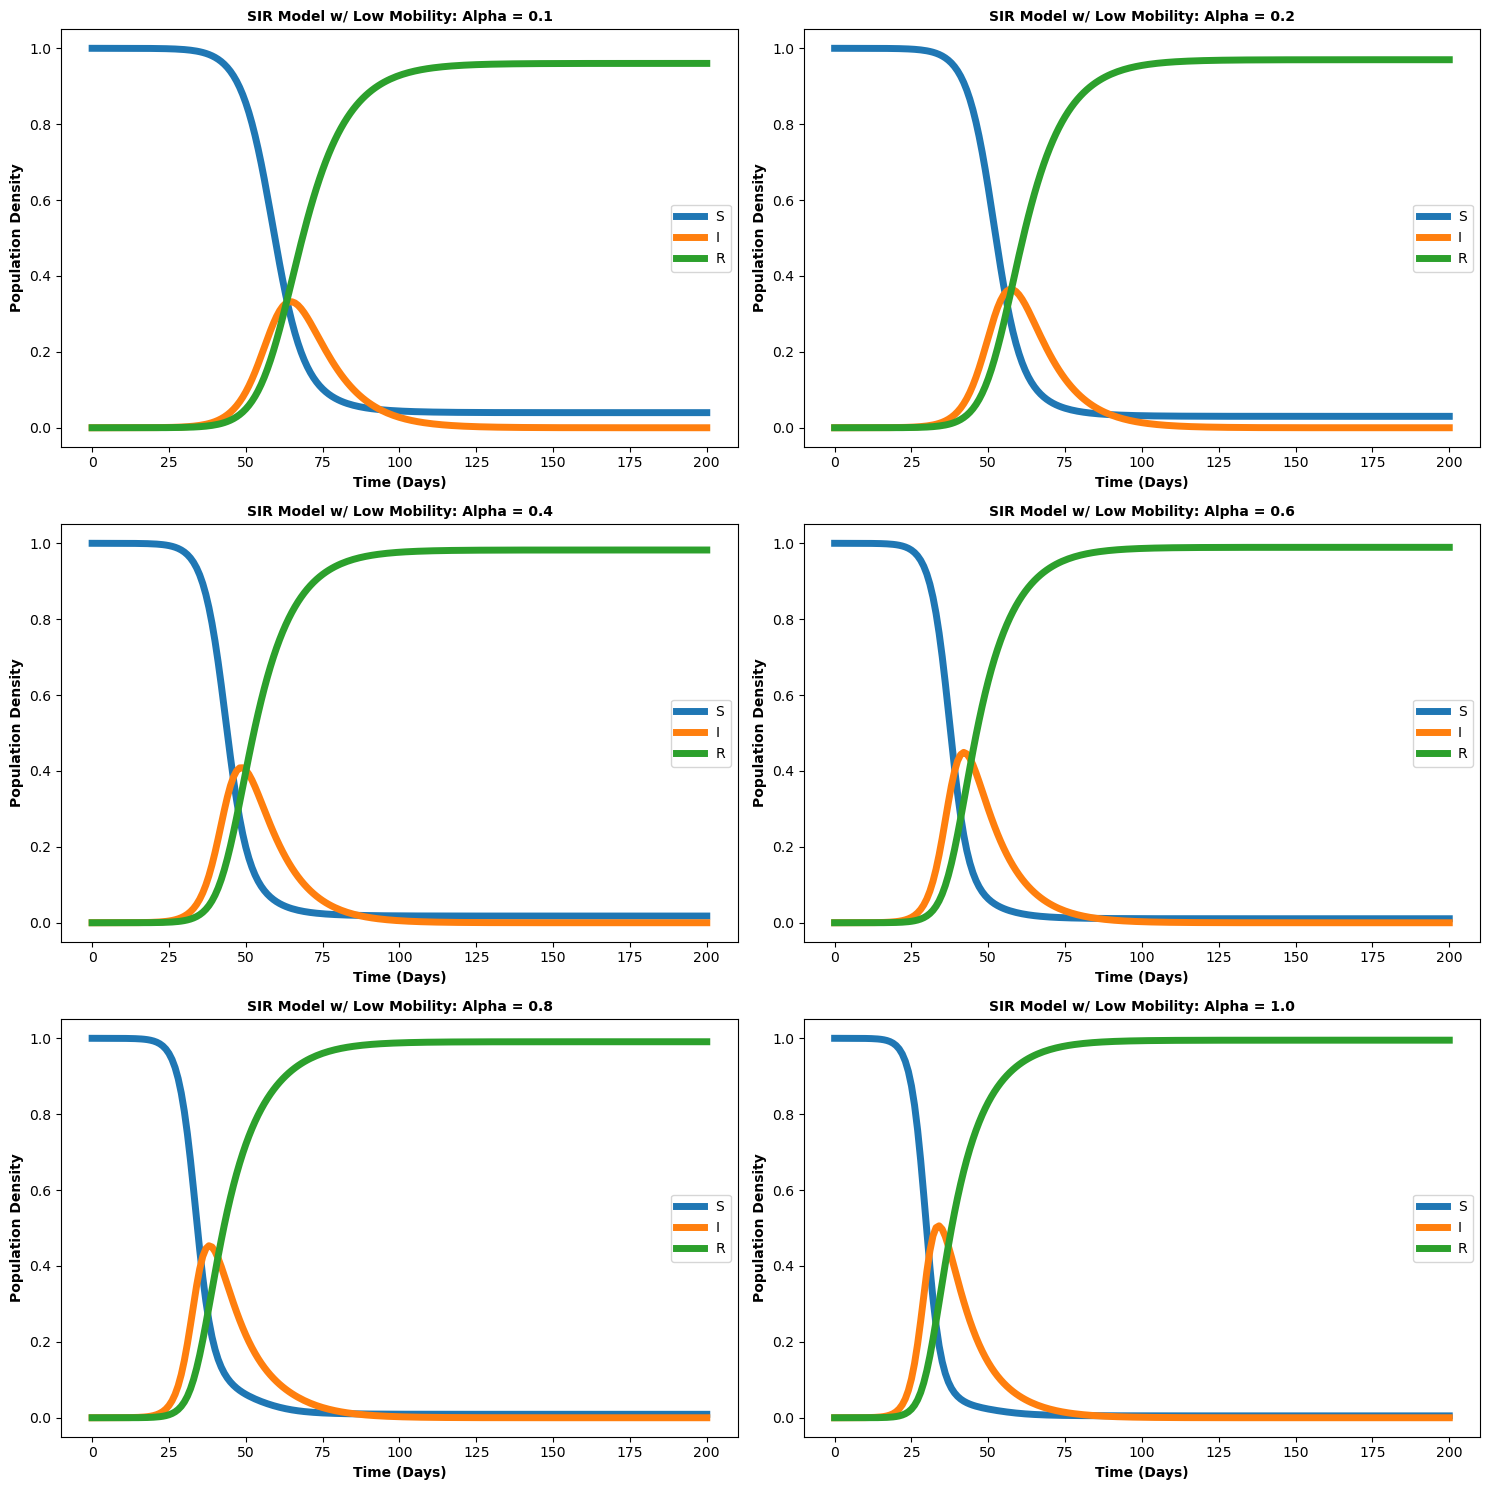

In [20]:
type = "Low"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results, type)